## Assignment 7

input으로 image를 하나 선택, k-means algorithm을 적용. 클러스터의 수와 intensity energy와 spatial energy 사이의 trade-off 고려

object function은 다음과 같다

$$ \sum_k \sum_\{ x \in I(k) \} [ \| f(x) - m_k \|^2 + a * \| x - c_k \|^2 ] $$

l(k): cluster k에 속하는 x의 index set

m_k: cluster k에 대한 image intensity의 centroid

c_k: cluster k에 대한 spatial location의 centroid

a: image intensity와 spatial location 사이의 중요성을 결정

1. 클러스터링된 결과를 visualization하기 (k를 다양하게 해보기, 클러스터마다 centroid color를 이용해서

2. intensity energy graph와 spatial energy graph를 visualization하기

# Import python module

clustering에 필요한 모듈들을 모두 import 한다

In [1]:
# module import 하기

import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time
from PIL import Image

# - clustering spatial location function -

## inspect duplicate centroid for location clustering

centroid 값이 비슷해져서 cluster가 없어질 경우를 방지하기 위한 함수이다

다른 centroid와 값의 차이가 0.005 이하일 경우 일정 값을 빼줘서 centroid 값들이 서로 차이가 나게 만든다

그렇게 하여 중복(값의 차이가 0.005이하)이 없을때까지 반복하여 중복을 없앤다.

In [2]:
def inspect_duplicate_centroid_of_location(centroid_x, centroid_y, cluster_num):
    while True:
        flag = 0
        flag_x = []
        flag_y = []
        for i in range(0, cluster_num):
            for j in range(i+1, cluster_num):
                if abs(centroid_x[i] - centroid_x[j]) <= 0.005:
                    flag_x.append([i,j])

        for i in range(0, cluster_num):
            for j in range(i+1, cluster_num):
                if abs(centroid_y[i] - centroid_y[j]) <= 0.005:
                    flag_y.append([i,j])

        for x in flag_x:
            for y in flag_y:
                if x == y:
                    centroid_x[x[0]] -= 0.005
                    centroid_y[y[0]] -= 0.007
                    flag -= 1
                else:
                    flag += 1
        
        size = len(flag_x) * len(flag_y)
        
        if flag == size:
            break

    return centroid_x, centroid_y

## Calculate centroid for location clustering

spatial location을 clustering하기 위해 필요한 centroid를 구하는 함수이다

해당하는 위치(픽셀위치)에서의 라벨 값을 받아서 각 라벨의 센트로이드에 x와 y 값을 모두 더해준다

그렇게 하여 해당하는 개수로 나눠준다

그리고 위에서 정의한 centroid 중복 검사 함수(inspect duplicate centroid of location)를 이용하여 중복을 제거하고

x좌표의 centroid와 y좌표의 centroid를 반환한다

In [3]:
def cal_centroid_location(x_matrix, y_matrix, data, numbers) : 
    row_num = numbers[0]
    column_num = numbers[1]
    cluster_num = numbers[2]
    
    centroid_x = np.zeros(cluster_num)
    centroid_y = np.zeros(cluster_num)
    count = np.zeros(cluster_num)
    
    for i in range(row_num):
        for j in range(column_num):
            label = int(data[i][j])
            centroid_x[label] += x_matrix[i][j]
            centroid_y[label] += y_matrix[i][j]
            count[label] += 1

    centroid_x /= count
    centroid_y /= count
    
    centroid_x, centroid_y = inspect_duplicate_centroid_of_location(centroid_x, centroid_y, cluster_num)
    
    return centroid_x, centroid_y

## Initialize random rable for spatial location

spatial location clusteirng에 필요한

x축 matrix(row matrix)와 y축 matrix(column matrix)를 만들어서 반환한다

In [4]:
def init_variable_for_clustering_location(row_num, column_num, cluster_num):
    x = []
    y = []
    
    data = np.zeros((row_num, column_num), dtype='i')
    
    # initialize row matrix
    for i in range(row_num):
        temp = [i for _ in range(row_num)]
        x += temp
    
    # initialize column matrix
    column = []
    for i in range(column_num):
        temp = [i for _ in range(1)]
        column += temp
    
    for i in range(column_num):
        y += column
    
    return x, y

## calculate distance of location clustering

L2_norm을 이용하여 spatial location clusteirng에 필요한 distance를 계산해서 반환한다

In [5]:
def distance_of_location(centroid_x, centroid_y, x, y):
    distance = 0
    distance += pow(centroid_x - x, 2)
    distance += pow(centroid_y - y, 2)
    
    return distance

# - image intensity clusteirng function -

## calculate centroid (clustering image intensity)

image intensity clustering을 할때 필요한 centroid를 구하는 함수이다

location을 clustering할때 centroid를 구하는 방식이랑 비슷하다

다른 점이라면 RGB 값 각각에 대해서 클러스터링 해야 되기 하나의 centroid에 3개의 값을 갖는다

그리고 똑같이 중복 centroid를 검사해서 없애줘서 centroid를 반환한다

In [6]:
def cal_centroid_intensity(label, data, numbers):
    row_num = numbers[0]
    column_num = numbers[1]
    cluster_num = numbers[2]
    
    clusters = np.zeros( (cluster_num, 3))
    label_count = np.zeros( cluster_num )
        
    for x in range(row_num):
        for y in range(column_num):
            image_label = int(label[x][y])
            clusters[image_label][0] += data[x][y][0]
            clusters[image_label][1] += data[x][y][1]
            clusters[image_label][2] += data[x][y][2]
            
            label_count[image_label] += 1
    
    for i in range(0, cluster_num):
        clusters[i] /= label_count[i]
    
    clusters = inspect_duplicate_centroid_of_intensity(clusters, cluster_num)
    return clusters

## inspect duplicate centroid of intensity clustering

중복된 centroid, 유사한 centroid 값을 가지는 centroid를 없애는 함수이다

RGB 값중 하나라도 비슷한 값이 있다면 일정한 값(0.007)을 빼서 중복을 없애준다

그렇게 하여 cluster가 사라지는것을 방지한다

In [7]:
def inspect_duplicate_centroid_of_intensity(image_centroid, cluster_num):
    while True:
        flag = 0
        flag_list = []
        for i in range(0, cluster_num):
            for j in range(i+1, cluster_num):
                temp_list = []
                temp_list = abs(image_centroid[i] - image_centroid[j])

                if temp_list[0] <= 0.007:
                    flag_list.append([i,j])
                elif temp_list[1] <= 0.007:
                    flag_list.append([i,j])
                elif temp_list[2] <= 0.007:
                    flag_list.append([i,j])

        if len(flag_list) == 0:
            break
        else:
            for x in flag_list:
                image_centroid[x[0]] -= 0.007

    return image_centroid

## calculate distance of intensity

L2_norm을 이용하여 distance를 구하는 함수이다

In [8]:
def distance_of_intensity(image_centroid, data):
    temp = [0 for _ in range(3)]
    distance = 0
    
    temp += pow(image_centroid - data, 2)

    for num in temp:
        distance += num
    return distance

# - common clustering function -

clusteirng 된 데이터를 image의 라벨에 해당하는 centroid로 바꿔주는 함수이다

In [9]:
def make_clustered_data(image_centroid, label, height, width):
    clustered_data = np.zeros( (height, width, 3))
    
    for i in range(height):
        for j in range(width):
            # image의 라벨에 해당하는 centroid로 바꿔주기
            clustered_data[i][j][0] = int(image_centroid[int(label[i][j])][0]) # red
            clustered_data[i][j][1] = int(image_centroid[int(label[i][j])][1]) # green
            clustered_data[i][j][2] = int(image_centroid[int(label[i][j])][2]) # blue
    
    return clustered_data

## Random Labeling

clustering 처음에 랜덤으로 라벨을 할당해주는 함수이다

In [10]:
def init_label(cluster_num, height, width):
    label = np.zeros((height, width))
    for k in range(0, height):
        for j in range(0, width):
            label[k][j] = int(random.randrange(0, cluster_num))
    
    return label

## Open image and read pixel data

image의 이름을 받아서 이미지를 numpy array 형태로 바꿔주는 함수이다

In [11]:
def open_image(image_name):
    # load image
    im = Image.open(image_name)
    
    # Fetch image pixel data to numpy array
    data = np.array(im)
    
    return data

## Plot image

image data를 받아서 image를 plot해주는 함수이다

In [12]:
def display_image(image):
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.imshow(image)

## update label of image

image intensity distance와 spatial location distance를 각각 구해서

objective function에 적용하여 가장 작은 값의 index를 argmin()으로 추출하여 label을 새로 업데이트 해주는 함수이다

In [13]:
def update_label_of_image(label, data, importance_degree, image_centroid, L2_centroid_x, L2_centroid_y, x_matrix, y_matrix, numbers):
    result = []
    location_distance = 0
    intensity_distance = 0
    energy = 0
    
    row_num = numbers[0]
    column_num = numbers[1]
    cluster_num = numbers[2]
    
    for k in range(row_num):
        for j in range(column_num):
            result = [0 for _ in range(cluster_num)]
            for i in range(cluster_num):
                intensity_distance = distance_of_intensity(image_centroid[i], data[k][j])
                intensity_distance /= row_num * column_num
                
                location_distance = distance_of_location(L2_centroid_x[i], L2_centroid_y[i], x_matrix[k][j], y_matrix[k][j])
                location_distance /= row_num*column_num*cluster_num
                
                result[i] = intensity_distance + importance_degree * location_distance
    
            result_arr = np.asfarray(result[0:cluster_num])
            label[k][j] = result_arr.argmin()
            energy += result_arr.min()

    return label, energy

## get average for RGB ( image intensity )

image intensity에 필요한 data의 average를 구해주는 함수이다

In [14]:
def get_average_RGB(data):
    temp_average = np.mean(data, axis=1)
    average = np.mean(temp_average, axis=0)
    return average

## get std for RGB ( image intensity)

image intensity에 필요한 data의 표준편차(std)를 구해주는 함수이다

In [15]:
def get_std_RGB(data, average, numbers):
    row_num = numbers[0]
    column_num = numbers[1]
    
    temp_std = np.subtract(data, average)
    temp_std = np.square(temp_std)
    
    temp_std = np.sum(temp_std, axis=1)
    temp_std = np.sum(temp_std, axis = 0)
    
    std = np.divide(temp_std, row_num*column_num)
    std = np.sqrt(std)
    return std

## Ger average for location (spatial location)
calculate average for x, y value

In [16]:
def get_average_location(location_data, numbers):
    row_num = numbers[0]
    column_num = numbers[1]
    
    average = np.sum(location_data)
    average = np.divide(average, row_num*column_num)
    
    return average

## get std for location (spatial location)

calculate std for x,y value

In [17]:
def get_std_location(location_data, average, numbers):
    row_num = numbers[0]
    column_num = numbers[1]
    
    temp_std = np.subtract(location_data, average)
    temp_std = np.square(temp_std)
    
    temp_std = np.sum(temp_std)
    std = np.divide(temp_std, row_num*column_num)
    std = np.sqrt(std)
    return std

## whitening

$$ \text{whitening value: } g(x) = {f(x) - \mu \over \sigma}$$
$$ \text{average: } \mu : {\sum_{i} f(x_i) \over |\Omega|}$$
$$ \text{standard deviation: } \sigma : { \sum_{i} (f(x_i) - \mu)^2 \over |\Omega|}$$
$$ \Omega : domain$$

In [18]:
def whitening_data(average, std, data):
    whitening_data = np.subtract(data, average)
    whitening_data = np.divide(whitening_data, std)
    
    return whitening_data

## Do clustering

clusteirng을 하는 함수이다

In [31]:
def clustering(cluster_num, importance_degree):
    image_name = "butterfly.jpg"

    original_data = open_image(image_name)
    intensity_data = original_data.copy()
    
    image_shape = original_data.shape
    
    # size of image
    width = image_shape[0]
    height = image_shape[1]
    numbers=[height, width, cluster_num]
    
    # random label initialize
    label = init_label(cluster_num, height, width)
        
    # x : horizontal list
    # y : vertical list
    # data : initialized data ( random label )
    x, y = init_variable_for_clustering_location(height, width, cluster_num)

    x_array = np.asfarray(x[0:height*width])
    x_matrix = x_array.reshape((height, width))

    y_array = np.asfarray(y[0:height*width])
    y_matrix = y_array.reshape((height, width))
    
    
    #######################
    # initialize variable #
    #######################
    prev_energy = 1000000
    energy = 0
    all_energy = []
    all_iteration = []
    cluster_count = 0
    threshold = 0.0001
    max_cluster = 300
    
    #############
    # whitening #
    #############
    average_RGB = get_average_RGB(intensity_data)
    std_RGB = get_std_RGB(intensity_data, average_RGB, numbers)
    intensity_data = whitening_data(average_RGB, std_RGB, intensity_data)
    
    average_x = get_average_location(x_matrix, numbers)
    average_y = get_average_location(y_matrix, numbers)
    std_x = get_std_location(x_matrix, average_x, numbers)
    std_y = get_std_location(y_matrix, average_y, numbers)
    x_matrix = whitening_data(average_x, std_x, x_matrix)
    y_matrix = whitening_data(average_y, std_y, y_matrix)   
    
    
    #################################
    # calculate centroid each label #
    #################################
    image_centroid = cal_centroid_intensity(label, intensity_data, numbers)
    
    L2_centroid_x, L2_centroid_y = cal_centroid_location(x_matrix, y_matrix, label, numbers)
    
    while(True):
        label, energy = update_label_of_image(label, intensity_data, importance_degree, image_centroid, L2_centroid_x, L2_centroid_y, x_matrix, y_matrix, numbers)
        
        all_energy.append(energy)
        all_iteration.append(cluster_count)
        
        # energy의 차이가 아주 작아지면 clustering 멈추기
        if prev_energy <= energy*(1 + threshold):
            break
        elif cluster_count >= max_cluster :
            break
        
        else:
            image_centroid = cal_centroid_intensity(label, intensity_data, numbers)
            L2_centroid_x, L2_centroid_y = cal_centroid_location(x_matrix, y_matrix, label, numbers)
            prev_energy = energy
            energy = 0
            cluster_count += 1
        
        # debugging
        if cluster_count % 10 == 0:
            print("clustering: ", cluster_count)
            

    image_centroid = np.multiply(image_centroid, std_RGB)
    image_centroid = np.add(image_centroid, average_RGB)
    
    clustered_data = make_clustered_data(image_centroid, label, height, width)
    
    # np.float64 -> np.uint8
    clustered_data = clustered_data.astype(np.uint8)

    # plot clustered image
    display_image(clustered_data)

    # plot enegy graph
    energy_graph = plt.figure("Energy Graph", figsize=(5,5))
    energy_graph.add_subplot(1,1,1).plot(all_iteration, all_energy)

    # plot
    plt.show()

# Original image

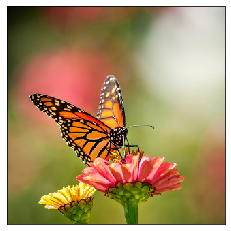

In [33]:
image_name = "butterfly.jpg"

original_data = open_image(image_name)

#plot origin image
display_image(original_data)

## 클러스터가 3개일때

cluster의 수가 3개일때를 테스트해보았다

첫 번째 인자는 cluster의 수를 나타내고 두 번째 인자는 objective function에서의 a 값을 나타낸다

우선 a의 값을 0으로 주고 진행하였다. 즉 image intensity에 대해서만 진행하였을때

정상적으로 clusterinig이 잘 되었고 energy도 잘 줄어드는 모습을 볼 수 있었다

clustering:  10


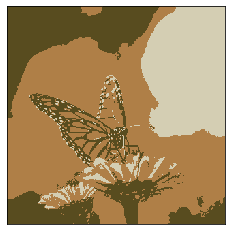

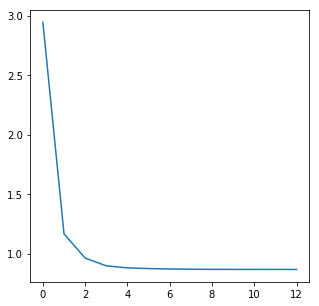

In [24]:
clustering(3, 0)

a가 1일때도 진행해보았다
즉 image intensity와 spatial location에 대해서 똑같은 중요도를 준것이다

이렇게 하였을때도 정상적으로 클러스터링 된 모습을 볼 수 있었다

하지만 a값을 0으로 하였을때와의 차이는 거의 없었다

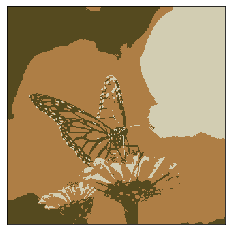

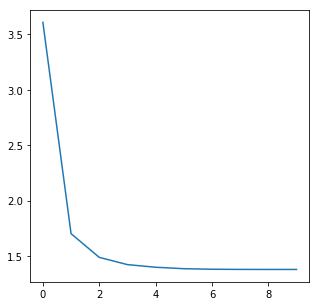

In [25]:
clustering(3, 1)

## cluster의 수가 5일때

cluster의 수가 5이고 a의 값이 2일때 클러스터링을 진행해보았다

정상적으로 클러스터링 된 모습을 볼 수 있다

clustering:  10


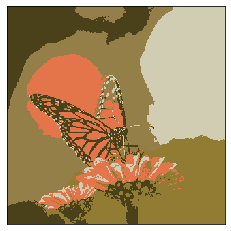

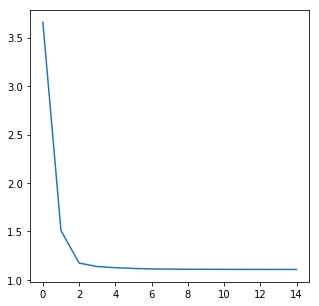

In [26]:
clustering(5, 2)

cluster의 개수는 똑같이 5로 한 상태에서 a의 값만 1로 변경해보았다

원본 이미지의 뒷 배경이 fade out 되어있어서 그런지 위와 크게 차이나지는 않지만

뒤쪽 배경이 더 잘 분리되어 나타난 모습을 볼 수 있다

clustering:  10
clustering:  20


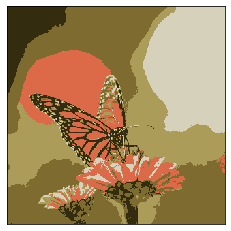

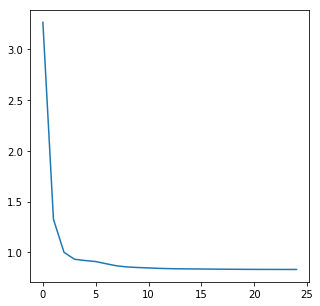

In [27]:
clustering(5, 1)

cluster의 수는 5로 두고 a를 엄청 크게 100으로 주었다
즉 spatial location에 대해 중요도를 크게 준것이다

그래서 image intensity에 대한 것은 무시가 되고 spatial location에 대한 clustering만 진행이 되었다

그래서 저번 6번 과제와 같이 동글동글한 모양을 그리며 색깔로만 나눠져 clustering된 모습을 볼 수 있다

clustering:  10


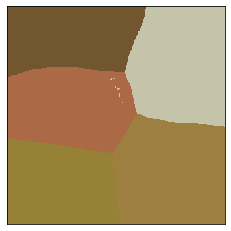

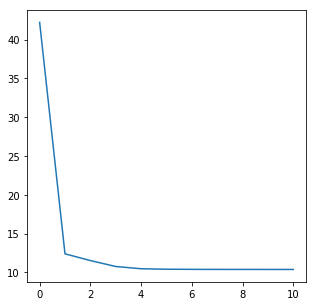

In [28]:
clustering(5, 100)

## cluster의 수가 12일때

cluster의 수를 12로 하고 a의 값을 1로 줘서 균등하게(위치와 값이 균등) clustering이 되도록 하였다

정상적으로 clustering 되고 energy가 잘 줄어드는 모습을 확인 할 수 있다

clustering:  10
clustering:  20
clustering:  30


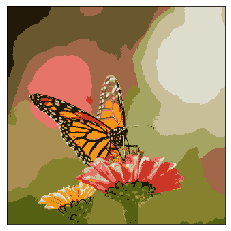

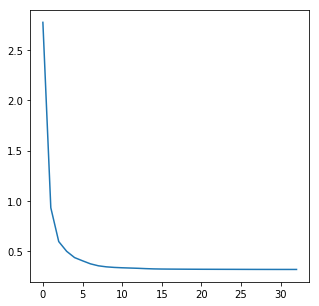

In [29]:
clustering(12, 1)

clsuter는 똑같이 12개이고 a의 값은 가장 많이 쓰인다는 0.7을 주고 해보았다

확실히 위에보다 위치의 값도 잘 고려되어서 잘 나누어진 모습을 볼 수 있다

clustering:  10
clustering:  20
clustering:  30


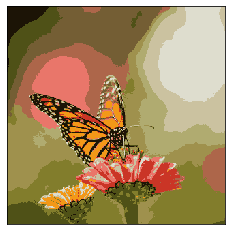

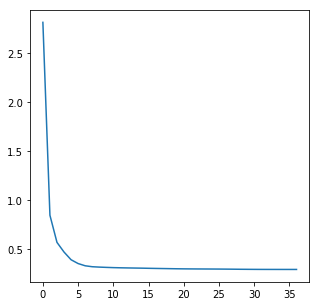

In [30]:
clustering(12, 0.7)